### Importing Libs

In [2]:
import datetime
import os
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf

### Input pipeline

In [5]:
CSV_COLUMNS = [
    "weight_pounds",
    "is_male",
    "mother_age",
    "plurality",
    "gestation_weeks",
]

LABEL_COLUMN = "weight_pounds"

NUMERICAL_COLUMNS = ["mother_age", "gestation_weeks"]
CATEGORICAL_COLUMNS = ["is_male", "plurality"]

DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0]]

In [6]:
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
    )
    dataset = dataset.map(map_func=features_and_labels)  # features, label
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    dataset = dataset.prefetch(buffer_size=1)
    return dataset

In [7]:
def create_input_layers():
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(1,), dtype="float32"
        )
        for colname in NUMERICAL_COLUMNS
    }

    inputs.update(
        {
            colname: tf.keras.layers.Input(
                name=colname, shape=(1,), dtype="string"
            )
            for colname in CATEGORICAL_COLUMNS
        }
    )

    return inputs

### Transformation Layer

In [8]:
def transform(inputs):
    transformed = {}
    for numerical_column in NUMERICAL_COLUMNS:
        transformed[numerical_column] = inputs[numerical_column]

    vocab = {
        "is_male": ["True", "False", "Unknown"],
        "plurality": [
            "Single(1)",
            "Twins(2)",
            "Triplets(3)",
            "Quadruplets(4)",
            "Quintuplets(5)",
            "Multiple(2+)",
        ],
    }

    for categorical_column in CATEGORICAL_COLUMNS:
        transformed[categorical_column] = tf.keras.layers.StringLookup(
            vocabulary=vocab[categorical_column], output_mode="one_hot"
        )(inputs[categorical_column])

    return transformed

### Ouput / Hidden Layers

In [9]:
def get_model_outputs(inputs):
    h1 = tf.keras.layers.Dense(64, activation="relu", name="h1")(inputs)
    h2 = tf.keras.layers.Dense(32, activation="relu", name="h2")(h1)
    output = tf.keras.layers.Dense(units=1, activation="linear", name="weight")(h2)
    return output

### Eval metric

In [10]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

### Training pipeline

In [17]:
def build_dnn_model():
    inputs = create_input_layers()
    transformed = transform(inputs)
    dnn_inputs = tf.keras.layers.Concatenate()(transformed.values())
    output = get_model_outputs(dnn_inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    return model
print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 is_male (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 plurality (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 mother_age (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 gestation_weeks (InputLayer)   [(None, 1)]          0           []                               
                                                        

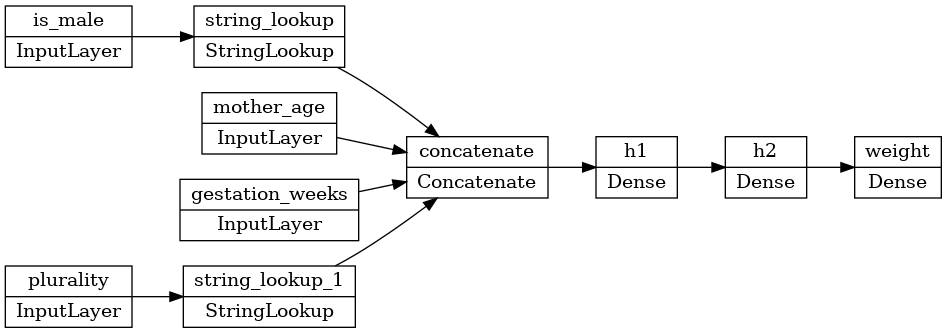

In [18]:
tf.keras.utils.plot_model(
    model=model, to_file="dnn_model.png", show_shapes=False, rankdir="LR"
)

In [20]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 
NUM_EVALS = 5 
NUM_EVAL_EXAMPLES = 10000

trainds = load_dataset(
    pattern="../datasets/baby-train*",
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

evalds = load_dataset(
    pattern="../datasets/baby-eval*", batch_size=1000, mode=tf.estimator.ModeKeys.EVAL
).take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1
)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback],
)

Epoch 1/5


2023-05-18 22:32:33.388837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 22:32:33.389341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


297/312 [===========================>..] - ETA: 0s - loss: 1.7265 - rmse: 1.2144 - mse: 1.7265

2023-05-18 22:32:36.513845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 22:32:36.514188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


312/312 [==============================] - 4s 5ms/step - loss: 1.6970 - rmse: 1.2062 - mse: 1.6970 - val_loss: 1.1695 - val_rmse: 1.0811 - val_mse: 1.1695
Epoch 2/5
312/312 [==============================] - 1s 5ms/step - loss: 1.1913 - rmse: 1.0793 - mse: 1.1913 - val_loss: 1.1816 - val_rmse: 1.0868 - val_mse: 1.1816
Epoch 3/5
312/312 [==============================] - 1s 4ms/step - loss: 1.2024 - rmse: 1.0853 - mse: 1.2024 - val_loss: 1.1682 - val_rmse: 1.0805 - val_mse: 1.1682
Epoch 4/5
312/312 [==============================] - 1s 5ms/step - loss: 1.1686 - rmse: 1.0712 - mse: 1.1686 - val_loss: 1.1378 - val_rmse: 1.0664 - val_mse: 1.1378
Epoch 5/5
312/312 [==============================] - 2s 5ms/step - loss: 1.1388 - rmse: 1.0560 - mse: 1.1388 - val_loss: 1.1200 - val_rmse: 1.0580 - val_mse: 1.1200


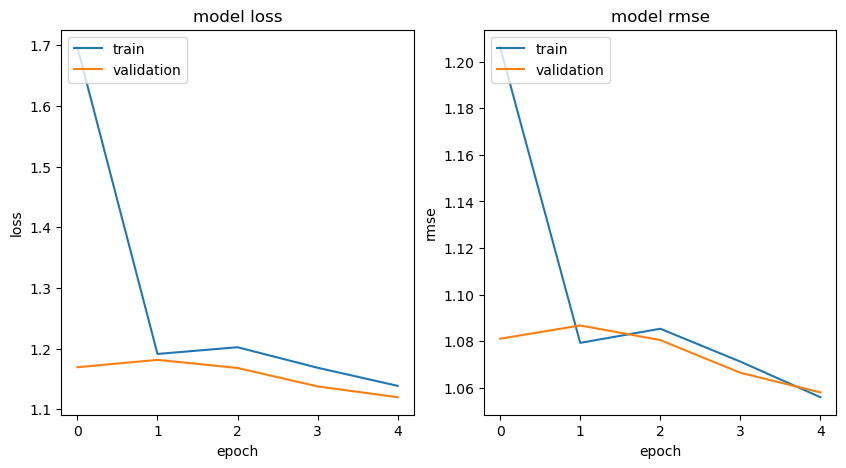

In [21]:
import matplotlib.pyplot as plt

nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx + 1)
    plt.plot(history.history[key])
    plt.plot(history.history[f"val_{key}"])
    plt.title(f"model {key}")
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

In [22]:
OUTPUT_DIR = "babyweight_trained"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(
    OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S")
)
tf.saved_model.save(
    obj=model, export_dir=EXPORT_PATH
)
print(f"Exported trained model to {EXPORT_PATH}")

INFO:tensorflow:Assets written to: babyweight_trained/20230518223300/assets


INFO:tensorflow:Assets written to: babyweight_trained/20230518223300/assets


Exported trained model to babyweight_trained/20230518223300
